***Name:*** Shehryar Ahmed  
**Roll No:** 22F-BSAI-28
**Department:** BS-Artificial Intelligence  
**Course:** Programming of AI  
**Submitted to:** Sir Hamza Farooqui  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_1samp, chi2_contingency
from scipy.integrate import odeint, solve_ivp

In [17]:

df = pd.read_csv('patient_data.csv') 
df.head()


,PatientID,Gender,Age,CholesterolLevel,BloodPressure,Region,RiskCategory
0,1,Male,37,193.4,129.4,East,High
1,2,Female,45,210.7,107.1,West,Low
2,3,Male,63,244.3,103.9,West,Low
3,4,Male,53,184.5,127.2,West,High
4,5,Male,29,175.7,116.6,South,High


### Feature Reduction

In [ ]:
selector = VarianceThreshold(threshold=0)  
selector.fit(df.select_dtypes(include=['float64', 'int64']))
df_var = df[df.select_dtypes(include=['float64', 'int64']).columns[selector.get_support()]]

df_var = pd.concat([df_var, df.select_dtypes(include=['object'])], axis=1)

### Detect & Remove Outliers from CholesterolLevel

In [5]:
Q1 = df_var['CholesterolLevel'].quantile(0.25)
Q3 = df_var['CholesterolLevel'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df_var[(df_var['CholesterolLevel'] >= lower_bound) & 
                        (df_var['CholesterolLevel'] <= upper_bound)]

In [6]:
df_no_outliers.shape

(98, 7)

### No missing values 

In [18]:
df_no_outliers.isnull().sum()

PatientID           0
Age                 0
CholesterolLevel    0
BloodPressure       0
Gender              0
Region              0
RiskCategory        0
dtype: int64

## Q2: Data Visualization
### Box Plot: BloodPressure by RiskCategory

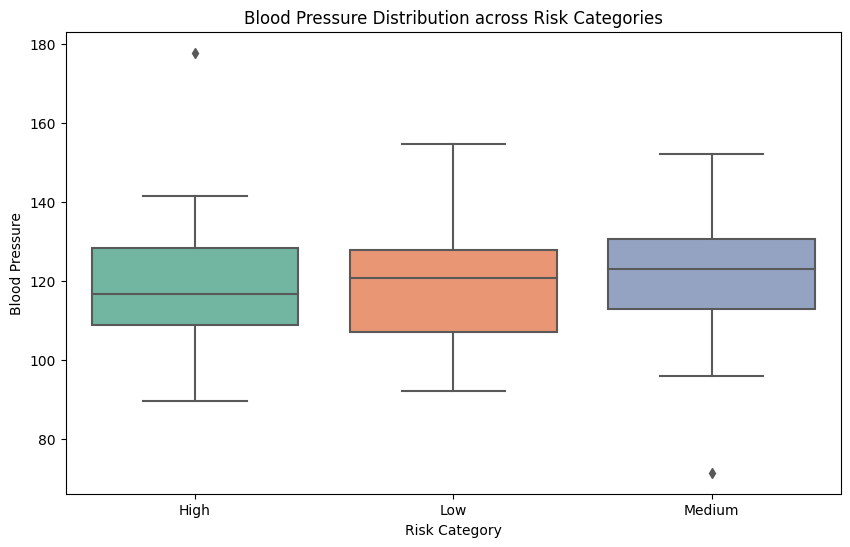

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='RiskCategory', y='BloodPressure', data=df_no_outliers, palette='Set2')
plt.title('Blood Pressure Distribution across Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Blood Pressure')
plt.show()

### Count Plot: Patients in each RiskCategory per Region


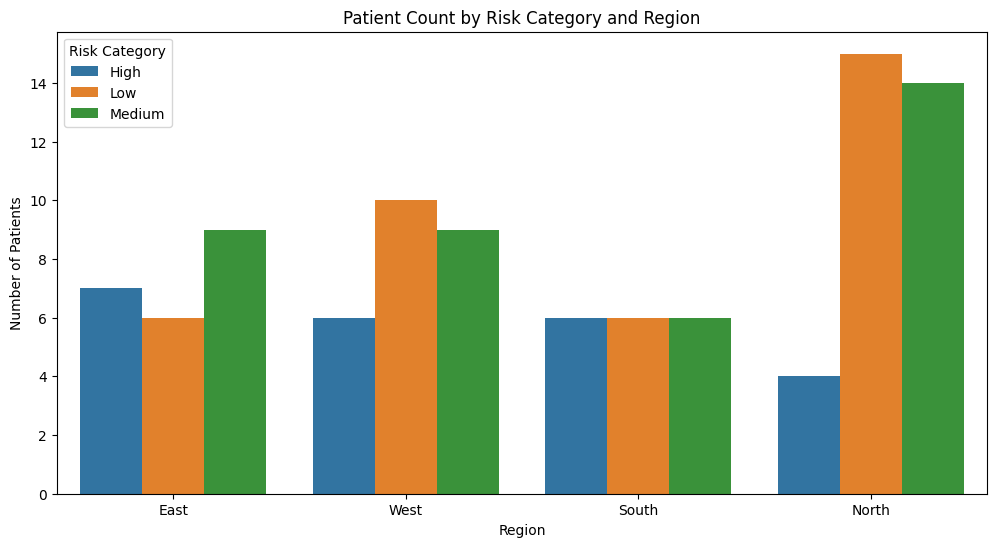

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Region', hue='RiskCategory', data=df_no_outliers)
plt.title('Patient Count by Risk Category and Region')
plt.xlabel('Region')
plt.ylabel('Number of Patients')
plt.legend(title='Risk Category')
plt.show()

## Q3: Statistical Hypothesis Testing
### Part 1: Is average Cholesterol Level significantly different from 200 mg/dL?

In [ ]:

sample = df_no_outliers['CholesterolLevel'].sample(n=20, random_state=42)

t_stat, p_value = ttest_1samp(sample, popmean=200)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: The average cholesterol level is significantly different from 200.")
else:
    print("Fail to reject the null hypothesis: No significant difference from 200.")


T-statistic: 1.1450
P-value: 0.2664
Fail to reject the null hypothesis: No significant difference from 200.


### Part 2: Is there a significant relationship between Region and RiskCategory?


In [ ]:

contingency_table = pd.crosstab(df_no_outliers['Region'], df_no_outliers['RiskCategory'])

chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Reject the null hypothesis: Region and RiskCategory are significantly related.")
else:
    print("Fail to reject the null hypothesis: No significant relationship between Region and RiskCategory.")

Chi-square Statistic: 4.8247
P-value: 0.5665
Fail to reject the null hypothesis: No significant relationship between Region and RiskCategory.


### Q4: Modeling a Health System with ODE


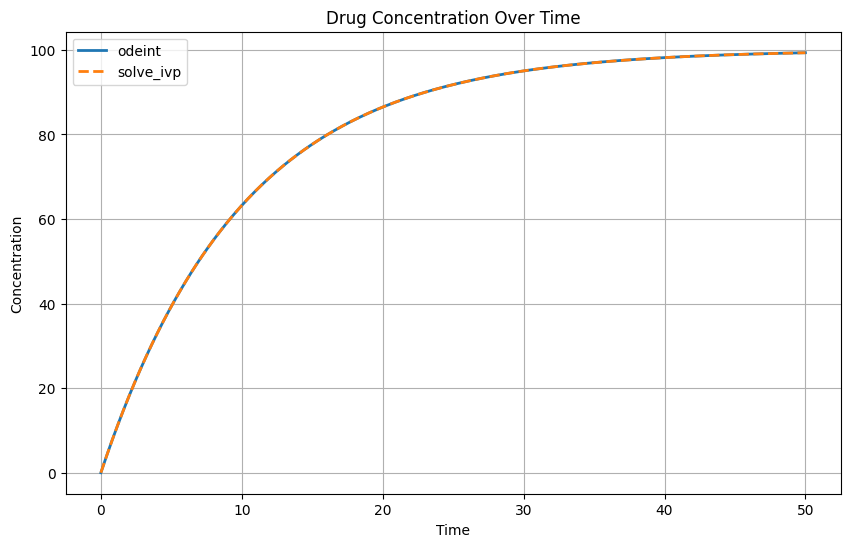

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt


def model(C, t, k, D):
    return k * (D - C)

k = 0.1
D = 100
C0 = 0
t = np.linspace(0, 50, 500)

# ---- odeint ----
C_odeint = odeint(model, C0, t, args=(k, D)).flatten()

# ---- solve_ivp ----
def model_ivp(t, C):
    return k * (D - C)

sol = solve_ivp(model_ivp, [0, 50], [C0], t_eval=t)
C_ivp = sol.y[0]

plt.figure(figsize=(10, 6))
plt.plot(t, C_odeint, label='odeint', linewidth=2)
plt.plot(t, C_ivp, '--', label='solve_ivp', linewidth=2)
plt.title('Drug Concentration Over Time')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


Both solvers produce similar results for this simple ODE, but solve_ivp offers more flexibility and control, while odeint is simpler and often faster.